<a href="https://colab.research.google.com/github/ppkgtmm/emotion/blob/sbigru/SBiGRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install -q keras-tuner
# !rm -r emotion
# !git clone --branch sbigru https://github.com/ppkgtmm/emotion.git emotion

In [4]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import  Tokenizer
from emotion.models import utils, bigru
from kerastuner.tuners.bayesian import BayesianOptimization
from kerastuner import HyperParameters

In [18]:
num_words = 15000
max_len = 300
hp = HyperParameters()
hp.Choice('output_dim',[128, 256])
hp.Choice('optimizer', ['adam', 'amsgrad'])
hp.Choice('gru_units', [32,64])
hp.Fixed('max_len', max_len)
hp.Fixed('num_words', num_words)
hp.Choice('n_layers', [2,3,4])
seed = 1234

In [9]:
train, test = utils.read_and_split()
train.sample(5)

,text,target
320,i do have to wonder when you re cast as a cave...,anger
19488,i managed however to relax and enjoy the scene...,love
6028,i feel drained after being out and about even ...,sadness
4857,i typically respond when i feel offended,anger
3326,i feel nostalgic for old books which i often r...,love


In [10]:
tokenizer = Tokenizer(num_words=num_words, oov_token='OOV')
tokenizer.fit_on_texts(train['text'])

In [11]:
sequence_train = utils.get_sequences(tokenizer, train['text'], max_len)
sequence_test = utils.get_sequences(tokenizer, test['text'], max_len)

In [12]:
target_train = utils.OH_fit_transform(train['target'])
target_test = utils.OH_transform(test['target'])

In [19]:
tuner = BayesianOptimization( bigru.build_stacked_bigru,
                              'val_accuracy',
                              12,
                              executions_per_trial=2,
                              hyperparameters=hp, 
                              seed=seed,
                              num_initial_points=5,
                              project_name='/content/drive/MyDrive/__ed__/sbigru_B32',
                            )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 128)          1920000   
_________________________________________________________________
bidirectional (Bidirectional (None, 300, 64)           31104     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                18816     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 1,970,310
Trainable params: 1,970,310
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = tuner.search(
            sequence_train, target_train,
            validation_split=0.1,
            epochs=3)

Trial 12 Complete [00h 04m 17s]
val_accuracy: 0.9358823597431183

Best val_accuracy So Far: 0.9358823597431183
Total elapsed time: 00h 56m 33s
INFO:tensorflow:Oracle triggered exit


In [21]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
output_dim (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'amsgrad'], 'ordered': False}
gru_units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64], 'ordered': True}
max_len (Fixed)
{'conditions': [], 'value': 300}
num_words (Fixed)
{'conditions': [], 'value': 15000}
n_layers (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4], 'ordered': True}


In [22]:
tuner.results_summary(num_trials=3)

Results summary
Results in /content/drive/MyDrive/__ed__/sbigru_B32
Showing 3 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
output_dim: 256
optimizer: amsgrad
gru_units: 64
max_len: 300
num_words: 15000
n_layers: 2
Score: 0.9358823597431183
Trial summary
Hyperparameters:
output_dim: 256
optimizer: adam
gru_units: 64
max_len: 300
num_words: 15000
n_layers: 4
Score: 0.9347058832645416
Trial summary
Hyperparameters:
output_dim: 256
optimizer: amsgrad
gru_units: 64
max_len: 300
num_words: 15000
n_layers: 2
Score: 0.9326470494270325


In [23]:
best_model = tuner.get_best_models(num_models=1)[0]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 256)          3840000   
_________________________________________________________________
bidirectional (Bidirectional (None, 300, 128)          123648    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               74496     
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 4,038,918
Trainable params: 4,038,918
Non-trainable params: 0
_________________________________________________________________


94/94 [==============================] - 3s 22ms/step
Accuracy:	92.6%


              precision    recall  f1-score   support

       anger       0.93      0.93      0.93       406
        fear       0.87      0.92      0.89       356
         joy       0.94      0.94      0.94      1014
        love       0.85      0.81      0.83       246
     sadness       0.96      0.97      0.97       870
    surprise       0.89      0.67      0.76       108

    accuracy                           0.93      3000
   macro avg       0.91      0.87      0.89      3000
weighted avg       0.93      0.93      0.93      3000



<Figure size 432x288 with 0 Axes>

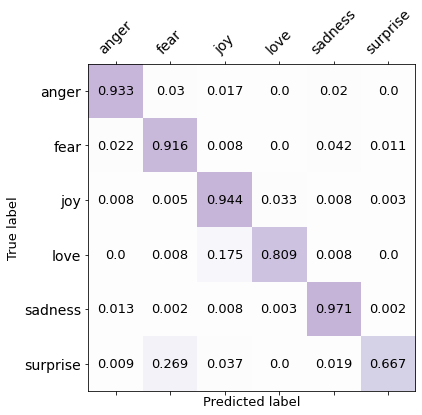

In [24]:
utils.model_evaluate(best_model, sequence_test, target_test, 32)

In [26]:
model = bigru.build_stacked_bigru(tuner.get_best_hyperparameters(num_trials=1)[0])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 256)          3840000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 300, 128)          123648    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               74496     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 4,038,918
Trainable params: 4,038,918
Non-trainable params: 0
_________________________________________________________________


In [27]:
cb = utils.get_callbacks('best_sbigru.h5')

In [28]:
history = model.fit(
    sequence_train, 
    target_train, 
    validation_split=0.1, 
    epochs=100,
    callbacks=cb
)

Epoch 1/100
479/479 [==============================] - 47s 87ms/step - loss: 1.2479 - accuracy: 0.5175 - precision_1: 0.6694 - recall_1: 0.2817 - val_loss: 0.2040 - val_accuracy: 0.9171 - val_precision_1: 0.9241 - val_recall_1: 0.9100

Epoch 00001: val_accuracy improved from -inf to 0.91706, saving model to best_sbigru.h5
Epoch 2/100
479/479 [==============================] - 40s 83ms/step - loss: 0.1541 - accuracy: 0.9347 - precision_1: 0.9405 - recall_1: 0.9307 - val_loss: 0.1611 - val_accuracy: 0.9312 - val_precision_1: 0.9337 - val_recall_1: 0.9276

Epoch 00002: val_accuracy improved from 0.91706 to 0.93118, saving model to best_sbigru.h5
Epoch 3/100
479/479 [==============================] - 39s 82ms/step - loss: 0.0719 - accuracy: 0.9704 - precision_1: 0.9716 - recall_1: 0.9698 - val_loss: 0.1987 - val_accuracy: 0.9271 - val_precision_1: 0.9295 - val_recall_1: 0.9235

Epoch 00003: val_accuracy did not improve from 0.93118
Epoch 4/100
479/479 [==============================] - 40s

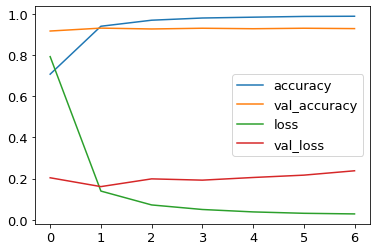

In [29]:
metr = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
pd.DataFrame(history.history)[metr].plot()

In [30]:
# utils.dump(tokenizer, '/content/drive/MyDrive/__ed__/sbigru_B32/tokenizer.pickle')
# utils.dump(history.history, '/content/drive/MyDrive/__ed__/sbigru_B32/history.pickle')

94/94 [==============================] - 3s 21ms/step
Accuracy:	92.8%


              precision    recall  f1-score   support

       anger       0.93      0.93      0.93       406
        fear       0.93      0.83      0.88       356
         joy       0.96      0.93      0.95      1014
        love       0.82      0.88      0.85       246
     sadness       0.96      0.98      0.97       870
    surprise       0.69      0.93      0.79       108

    accuracy                           0.93      3000
   macro avg       0.88      0.91      0.89      3000
weighted avg       0.93      0.93      0.93      3000



<Figure size 432x288 with 0 Axes>

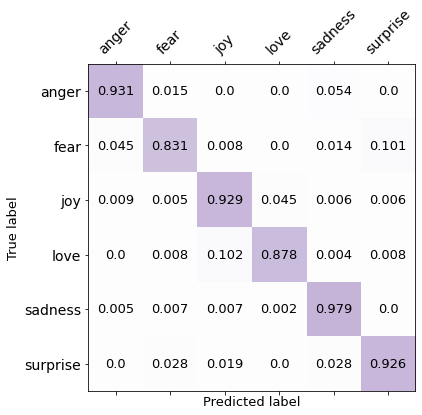

In [31]:
utils.model_evaluate(model, sequence_test, target_test, 32)

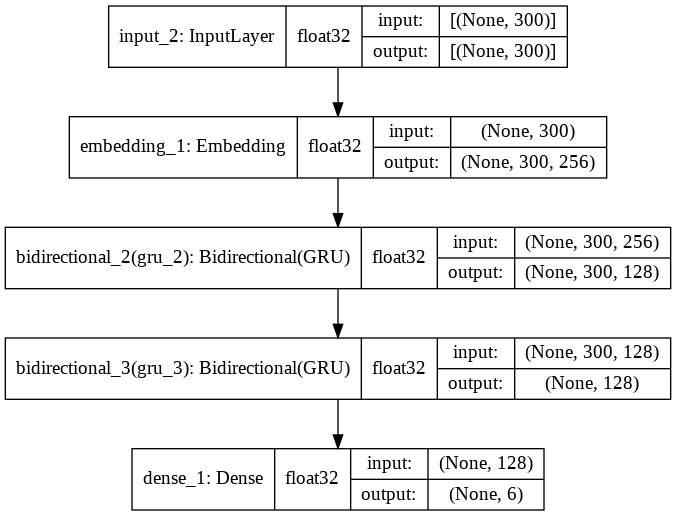

In [32]:
from keras.utils import plot_model
plot_model(
    model,
    to_file='/content/drive/MyDrive/__ed__/sbigru_B32/plot.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True
    )